In [1]:
# Paypal impact on bitcoin


In [1]:
#install libraries
!pip install yfinance
!pip install tfcausalimpact

In [2]:
#import libraries
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Dates
training_start = "2020-09-01"
training_end = "2020-10-19"
treatment_start = "2020-10-20"
treatment_end = "2020-10-23"
end_stock = "2020-10-24"


In [4]:
#Bitcoin
y = ["BTC-USD"]
y = yf.download(tickers = y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y['Adj Close'].rename("y")
y[:1]

[*********************100%%**********************]  1 of 1 completed


Date
2020-09-01    11970.478516
Name: y, dtype: float64

In [15]:
#Load more stock data
stocks = ["ZAL.DE", "SQ", "CRSP", "TRMB", "JD", "DE", "KTOS", "GOOG"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")


[*********************100%%**********************]  8 of 8 completed


In [16]:
#Getting the adjusted close
X = X.iloc[:, :len(stocks)]
X.head(1)

Adj Close                                                         \
                 CRSP          DE     GOOG         JD       KTOS          SQ   
Date                                                                           
2020-09-01  93.419998  210.029663  83.0355  79.267685  19.700001  166.660004   

                          
             TRMB ZAL.DE  
Date                      
2020-09-01  53.41   77.0

In [17]:
#Removing level
X.columns = X.columns.droplevel()
X.head(1)

,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,
2020-09-01,93.419998,210.029663,83.0355,79.267685,19.700001,166.660004,53.41,77.0


In [18]:
#Time zones
X.index = X.index.tz_localize(None)
X.index

DatetimeIndex(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
               '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
               '2020-09-11', '2020-09-14', '2020-09-15', '2020-09-16',
               '2020-09-17', '2020-09-18', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24', '2020-09-25', '2020-09-28',
               '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14',
               '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23'],
              dtype='datetime64[ns]', name='Date', freq='B')

In [19]:
#Combine everything
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029663,83.035500,79.267685,19.700001,166.660004,53.410000,77.000000
2020-09-02,11414.034180,93.930000,209.470078,86.414001,79.959564,19.910000,162.880005,54.310001,77.000000
2020-09-03,10245.296875,85.690002,203.391785,82.092003,75.952454,19.520000,152.860001,50.900002,75.080002
2020-09-04,10511.813477,82.019997,203.903091,79.552002,76.874954,19.260000,146.389999,49.959999,71.739998
2020-09-08,10131.516602,81.459999,202.841843,76.619499,73.242615,19.230000,139.110001,49.139999,73.440002


In [20]:
#Prepare a dataframe with only training data
df_training = df[df.index <= training_end]
df_training.tail(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-10-19,11742.037109,107.720001,230.57872,76.730499,77.461121,20.639999,186.960007,51.970001,85.0


In [21]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = df_training.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is not stationary


In [22]:
#Differencing: subtract or divide
differencing = df_training.pct_change().dropna()
differencing.head(2)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB,ZAL.DE
Date,,,,,,,,,
2020-09-02,-0.046485,0.005459,-0.002664,0.040687,0.008728,0.010660,-0.022681,0.016851,0.000000
2020-09-03,-0.102395,-0.087725,-0.029017,-0.050015,-0.050114,-0.019588,-0.061518,-0.062788,-0.024935


In [23]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
test = adfuller(x = differencing.y)[1]

#how to read - ifelse
if test < 0.05:
  print("The Time Series is stationary")
else:
  print("The Time Series is not stationary")

The Time Series is stationary


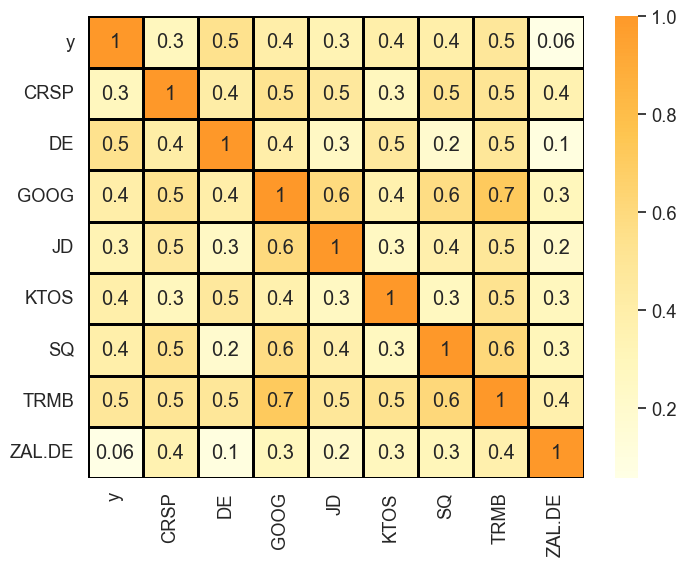

In [24]:
#Correlation Matrix
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
sns.heatmap(differencing.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'YlOrBr',
            center =  True,
            linewidth = 1,
            linecolor = 'black')
plt.show()

In [25]:
df_final = df.drop(columns = ["ZAL.DE"])
df_final.head(1)

,y,CRSP,DE,GOOG,JD,KTOS,SQ,TRMB
Date,,,,,,,,
2020-09-01,11970.478516,93.419998,210.029663,83.0355,79.267685,19.700001,166.660004,53.41


In [26]:
#Pre and post period
pre_period = [training_start, training_end]
post_period = [treatment_start, treatment_end]

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


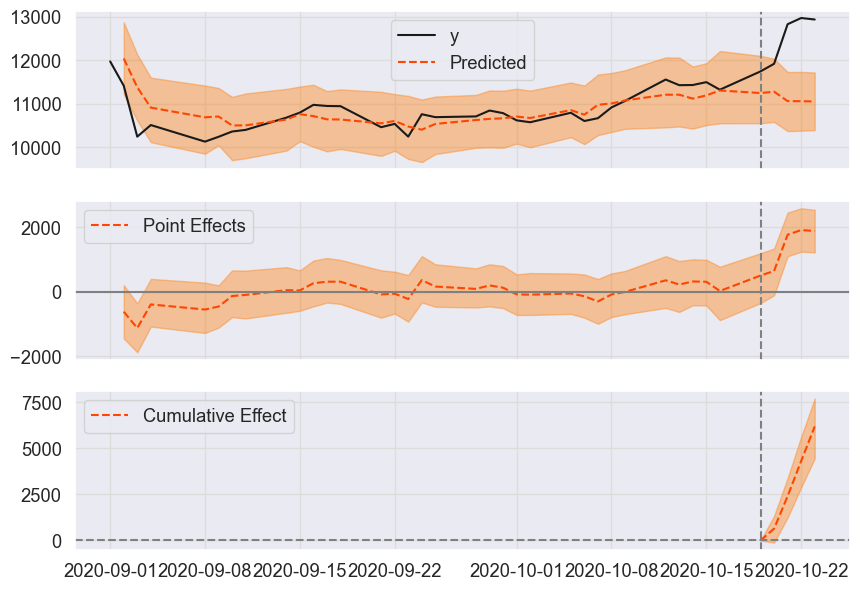

In [27]:
#Google Causal Impact
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)
impact.plot()

In [28]:
#Summary
print(impact.summary())
#1634

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12659.36           50637.45
Prediction (s.d.)         11112.26 (213.71)  44449.04 (854.83)
95% CI                    [10696.89, 11534.61][42787.57, 46138.42]

Absolute effect (s.d.)    1547.1 (213.71)    6188.41 (854.83)
95% CI                    [1124.76, 1962.47] [4499.03, 7849.89]

Relative effect (s.d.)    13.92% (1.92%)     13.92% (1.92%)
95% CI                    [10.12%, 17.66%]   [10.12%, 17.66%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [29]:
#Summary report
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 12659.36. By contrast, in the absence of an
intervention, we would have expected an average response of 11112.26.
The 95% interval of this counterfactual prediction is [10696.89, 11534.61].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1547.1 with a 95% interval of
[1124.76, 1962.47]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 50637.45.
By contrast, had the intervention not taken place, we would have expected
a sum of 44449.04. The 95% interval of this prediction is [42787.57, 46138.42].


The above results are given in terms of absolute numbers. In relative
t